In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=FutureWarning)

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:

df = pd.read_csv('../input/delhids/Dataset.csv')
print(type(df)) 

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
df = df.sort_index()  


<class 'pandas.core.frame.DataFrame'>


In [3]:
def create_features(df):
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

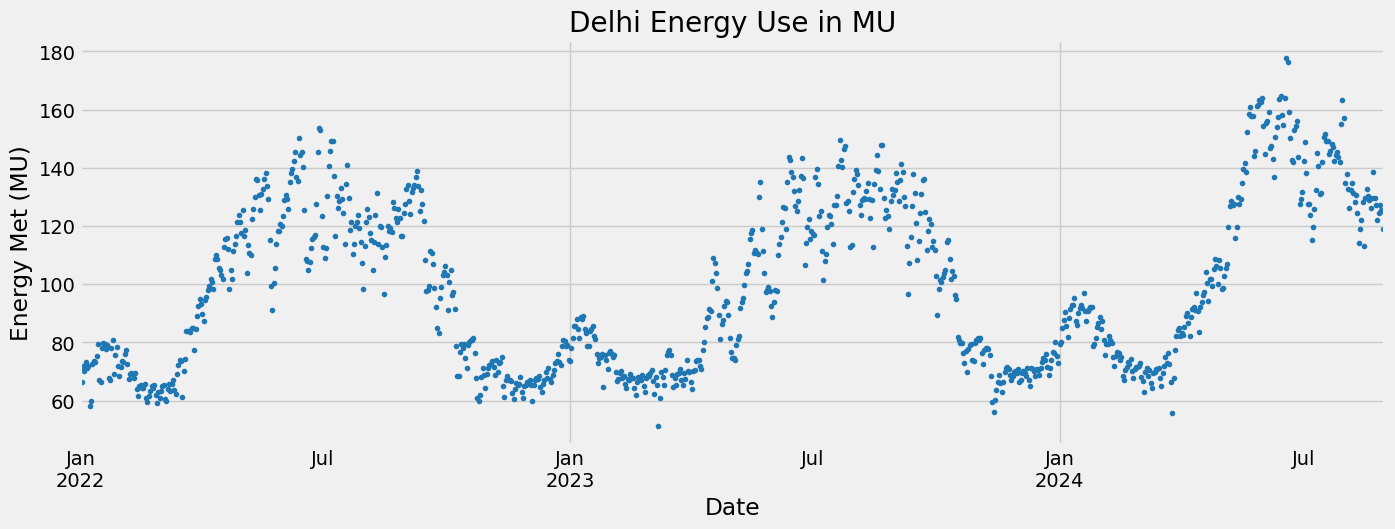

In [4]:
df['Energy Met (MU)'].plot(style='.',
                      figsize=(15,5),
                      color=color_pal[0],
                      title='Delhi Energy Use in MU')
plt.xlabel('Date')
plt.ylabel('Energy Met (MU)')
plt.show()

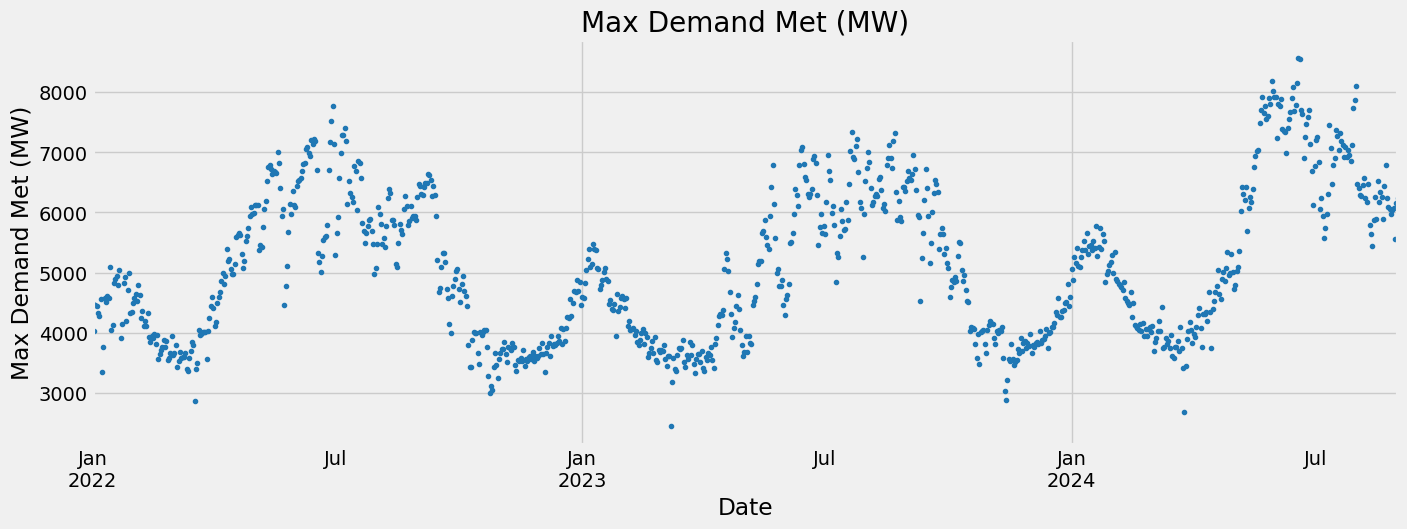

In [5]:
df['Max Demand Met (MW)'].plot(style='.',
                      figsize=(15,5),
                      color=color_pal[0],
                      title='Max Demand Met (MW)')
plt.xlabel('Date')
plt.ylabel('Max Demand Met (MW)')
plt.show()

<Axes: xlabel='Date'>

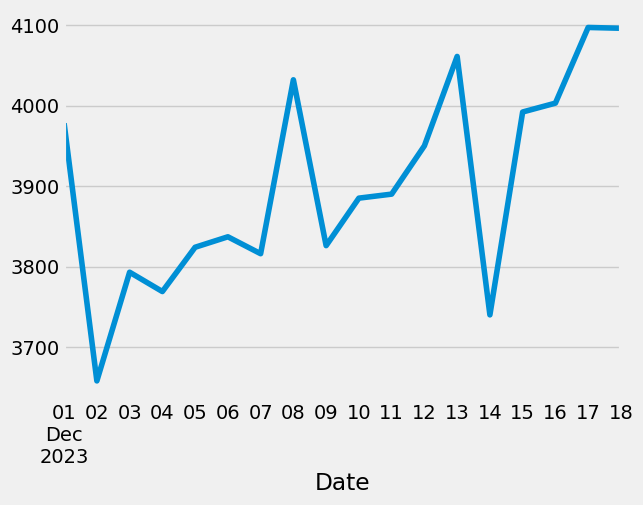

In [6]:
df['Max Demand Met (MW)'].loc[(df.index >= '12-01-2023')  & (df.index <= '12-18-2023')].plot()

<Axes: xlabel='Date'>

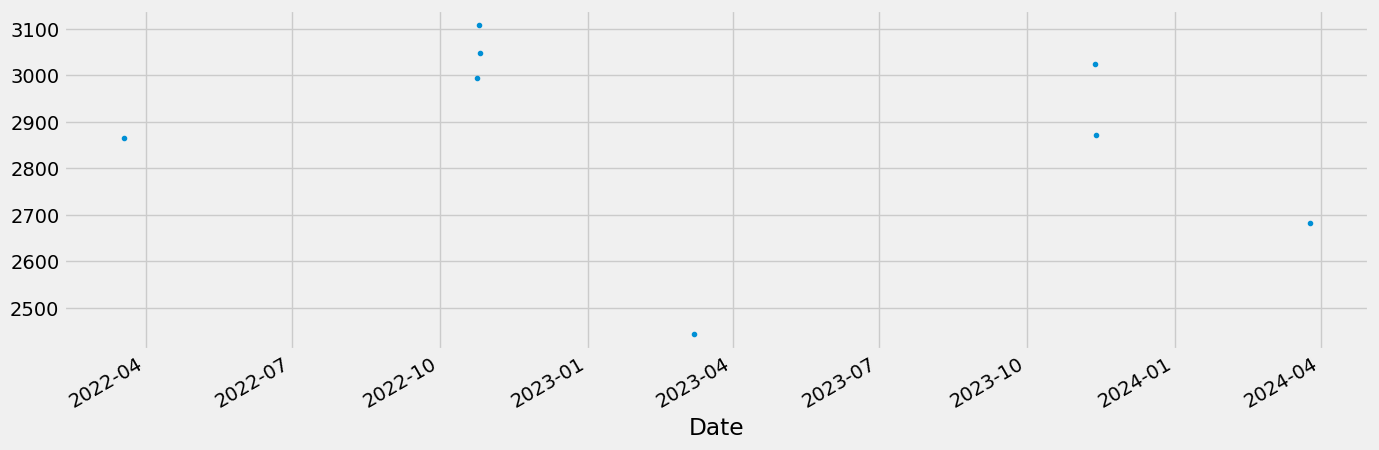

In [7]:
df.query('`Max Demand Met (MW)` < 3150')['Max Demand Met (MW)'].plot(figsize=(15,5), style='.')


In [8]:
df = df.query('`Max Demand Met (MW)` > 3150').copy()

# Train/Test Split

In [9]:
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()

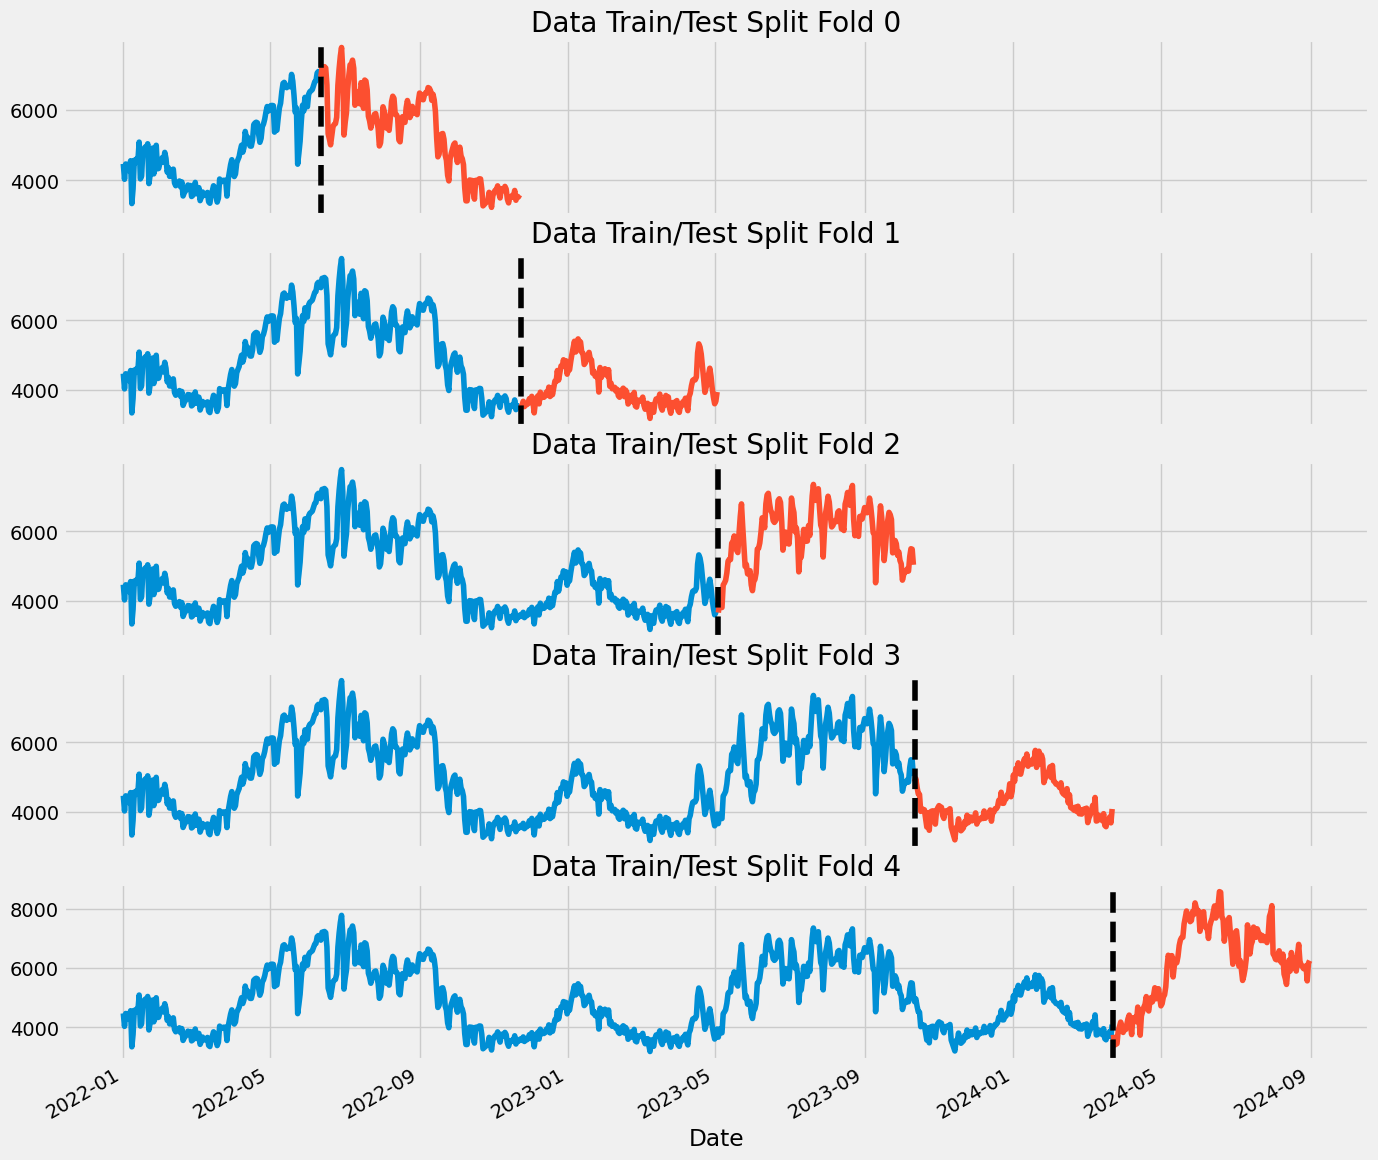

In [10]:

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train['Max Demand Met (MW)'].plot(ax=axs[fold],
                                     label='Training Set',
                                     title=f'Data Train/Test Split Fold {fold}')

    test['Max Demand Met (MW)'].plot(ax=axs[fold],
                                    label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')

    fold += 1

plt.show()


In [11]:
def add_lags(df):

    for target in ['Max Demand Met (MW)', 'Energy Met (MU)']:
        target_map = df[target].to_dict()
        
        for i in range(1, 8):
            df[f'{target}_lag{i}'] = (df.index - pd.Timedelta(f'{i} days')).map(target_map)
    
    return df
df = add_lags(df)

# Visualize F/T Relationship

<Axes: xlabel='month', ylabel='Max Demand Met (MW)'>

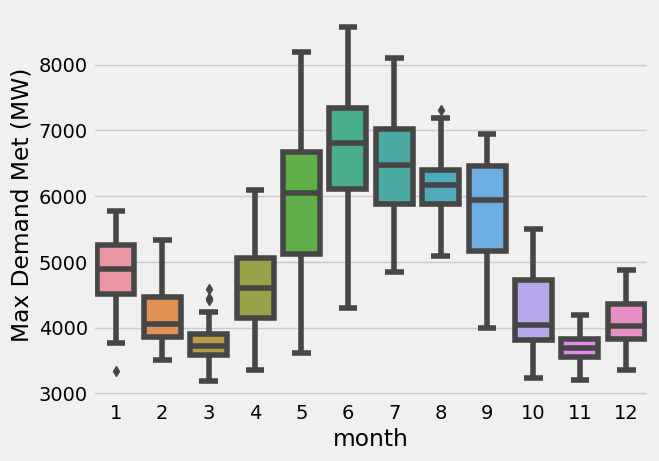

In [12]:
sns.boxplot(data=df, x='month', y='Max Demand Met (MW)')

In [13]:
Q1 = df['Energy Met (MU)'].quantile(0.25)
Q3 = df['Energy Met (MU)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Energy Met (MU)'] >= lower_bound) & (df['Energy Met (MU)'] <= upper_bound)]

<Axes: xlabel='month', ylabel='Energy Met (MU)'>

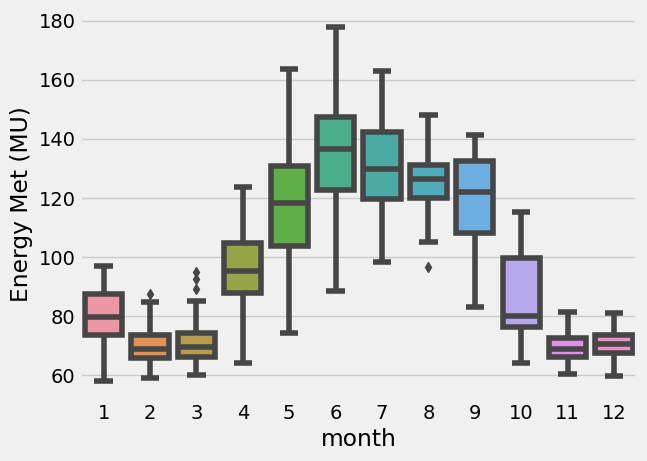

In [14]:
sns.boxplot(data=df,x='month',y = 'Energy Met (MU)')

# The Model 

In [15]:
model_dict = {
    target: xgb.XGBRegressor(
        base_score=0.5, booster='gbtree', n_estimators=1000,
        early_stopping_rounds=50, objective='reg:squarederror',
        max_depth=3, learning_rate=0.01
    ) for target in ['Max Demand Met (MW)', 'Energy Met (MU)']
}

preds = {target: [] for target in ['Max Demand Met (MW)', 'Energy Met (MU)']}
scores = {target: [] for target in ['Max Demand Met (MW)', 'Energy Met (MU)']}


In [16]:
FEATURES = ['dayofweek', 'tempmax', 'tempmin', 'temp', 'feelslike', 'cloudcover', 
            'dew', 'humidity', 'solarenergy', 'quarter', 'month', 'year', 
            'dayofmonth', 'weekofyear']

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    for TARGET in ['Max Demand Met (MW)', 'Energy Met (MU)']:
        X_train = train[FEATURES]
        y_train = train[TARGET]

        X_test = test[FEATURES]
        y_test = test[TARGET]
        
        model = model_dict[TARGET]
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
        
        y_pred = model.predict(X_test)
        preds[TARGET].append(y_pred)
        
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores[TARGET].append(score)


[0]	validation_0-rmse:4922.02057	validation_1-rmse:5384.72568
[100]	validation_0-rmse:1875.00833	validation_1-rmse:2208.22595
[200]	validation_0-rmse:740.35188	validation_1-rmse:1300.04349
[300]	validation_0-rmse:321.15913	validation_1-rmse:1043.52536
[400]	validation_0-rmse:175.65343	validation_1-rmse:955.35997
[500]	validation_0-rmse:125.32746	validation_1-rmse:936.40593
[600]	validation_0-rmse:106.32877	validation_1-rmse:920.23591
[700]	validation_0-rmse:95.33971	validation_1-rmse:907.23088
[800]	validation_0-rmse:86.90500	validation_1-rmse:899.18552
[900]	validation_0-rmse:79.69800	validation_1-rmse:890.82787
[999]	validation_0-rmse:73.50624	validation_1-rmse:885.15420
[0]	validation_0-rmse:93.20468	validation_1-rmse:107.94476
[100]	validation_0-rmse:35.47910	validation_1-rmse:47.89607
[200]	validation_0-rmse:13.89856	validation_1-rmse:25.73298
[300]	validation_0-rmse:5.88104	validation_1-rmse:18.81857
[400]	validation_0-rmse:2.97868	validation_1-rmse:16.62580
[500]	validation_0-rm

In [17]:
for target in ['Max Demand Met (MW)', 'Energy Met (MU)']:
    print(f"Scores for {target}: {scores[target]}")
    print(f"Mean Score for {target}: {np.mean(scores[target])}")


Scores for Max Demand Met (MW): [885.1542015733451, 350.2282726527287, 499.12489559057195, 334.1936605599429, 560.5655362759817]
Mean Score for Max Demand Met (MW): 525.8533133305141
Scores for Energy Met (MU): [14.85239558046897, 6.317528075169525, 8.472236715444536, 5.636878696009029, 12.103887750641576]
Mean Score for Energy Met (MU): 9.476585363546727


# Factors Importance

In [18]:
def plot_feature_importances(model, feature_names, title):
    fi = pd.DataFrame(data=model.feature_importances_, index=feature_names, columns=['importance'])
    fi.sort_values('importance').plot(kind='barh', title=title)
    plt.show()


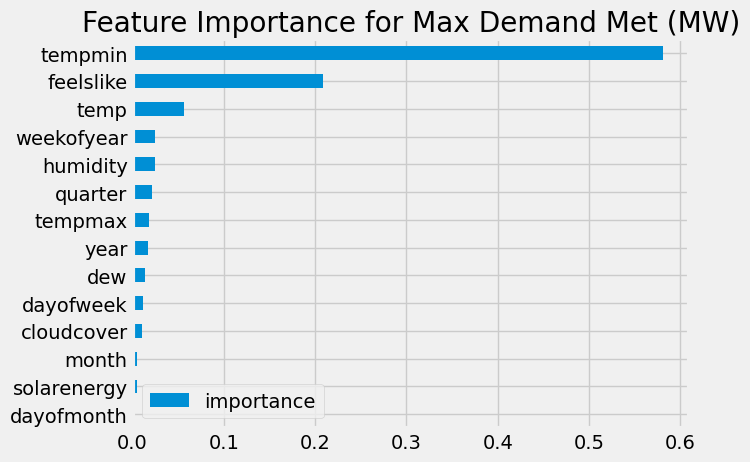

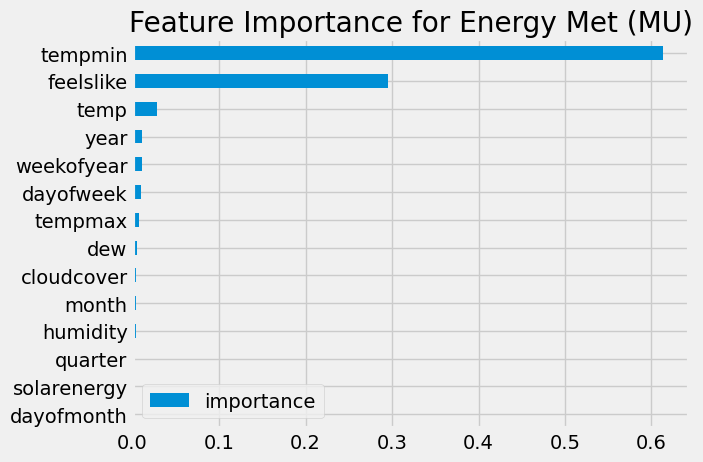

In [19]:
for TARGET in ['Max Demand Met (MW)', 'Energy Met (MU)']:
    model = model_dict[TARGET]
    plot_feature_importances(model, X_train.columns, f'Feature Importance for {TARGET}')


# Test Prediction

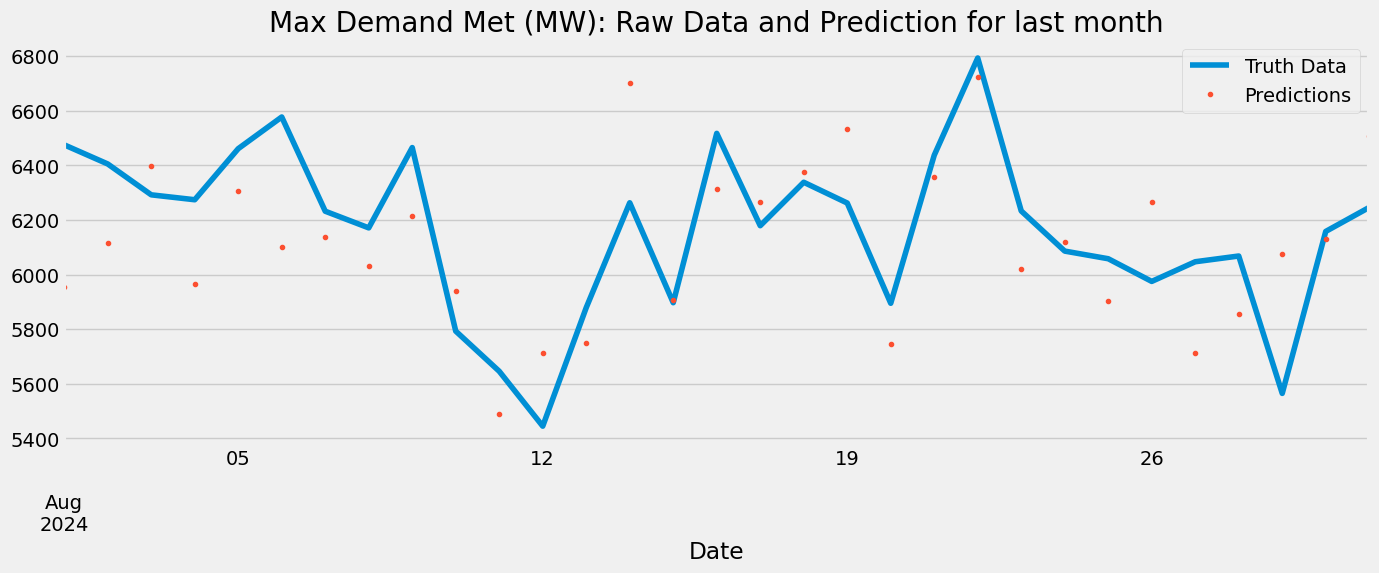

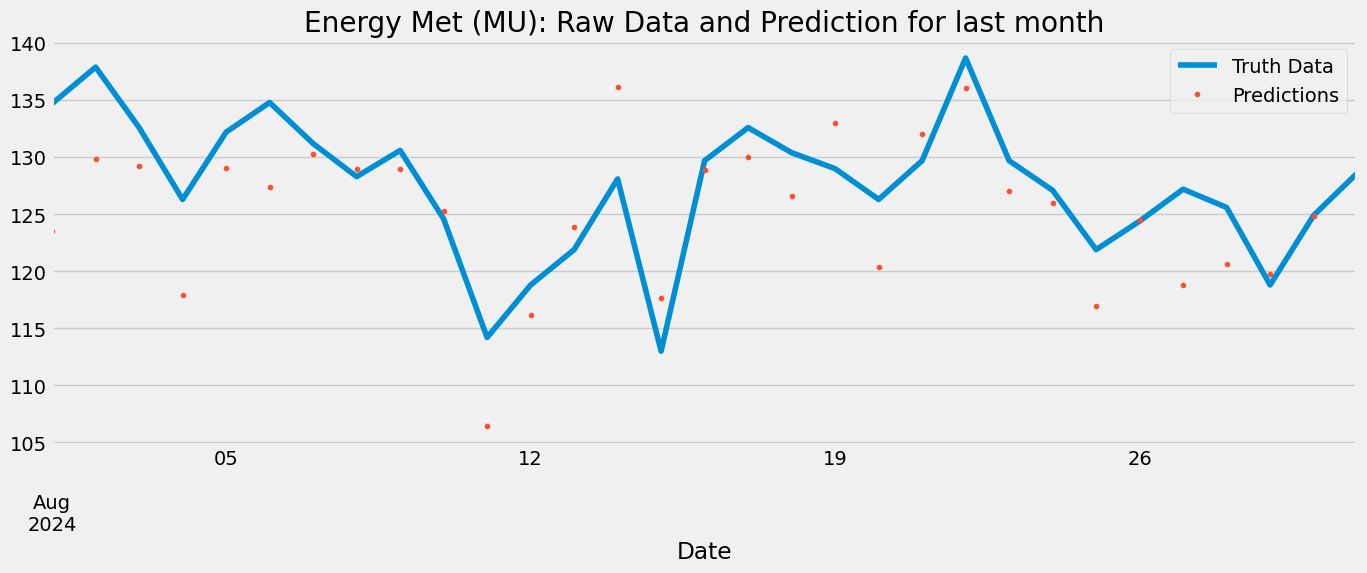

In [20]:
for TARGET in ['Max Demand Met (MW)', 'Energy Met (MU)']:
    model = model_dict[TARGET]
    
    test['prediction_' + TARGET.replace(' ', '_')] = model.predict(X_test)

last_month = 8 
test_filtered = test[test['month'] == last_month]  

ax = test_filtered[['Max Demand Met (MW)']].plot(figsize=(15, 5))
test_filtered['prediction_Max_Demand_Met_(MW)'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title(f'Max Demand Met (MW): Raw Data and Prediction for last month')
plt.show()

ax = test_filtered[['Energy Met (MU)']].plot(figsize=(15, 5))
test_filtered['prediction_Energy_Met_(MU)'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title(f'Energy Met (MU): Raw Data and Prediction for last month')
plt.show()


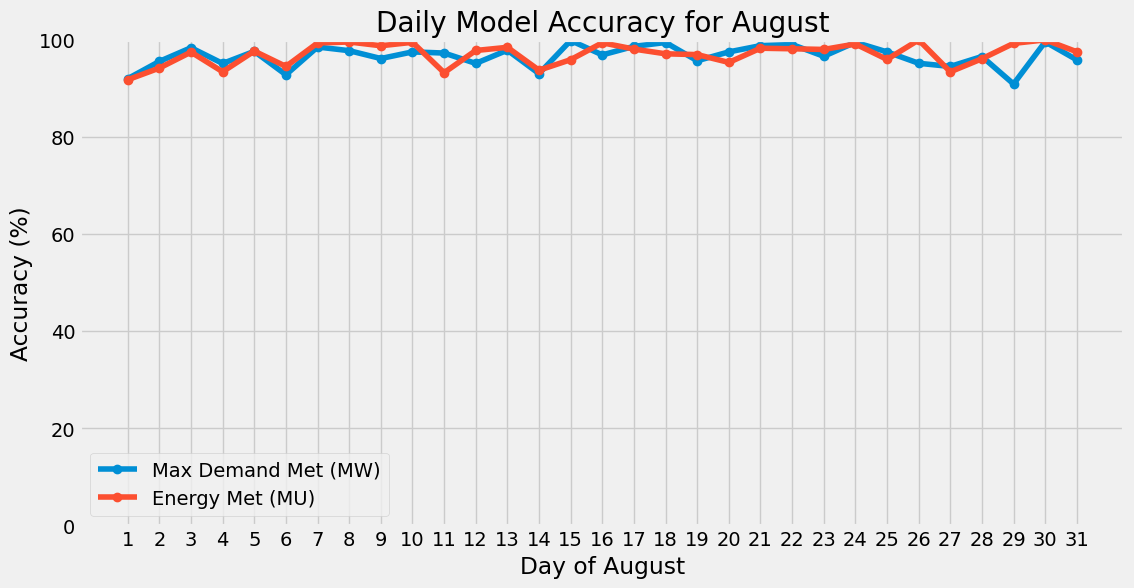

Average Accuracy for Max Demand Met (MW): 96.63%
Average Accuracy for Energy Met (MU): 96.99%


In [21]:
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
test_filtered = test[test.index.month == 8]  

test_filtered = test_filtered.copy()  # Ensure we work on a copy to avoid SettingWithCopyWarning
test_filtered['day'] = test_filtered.index.day


def calculate_mape(df, actual_col, prediction_col):
    return mean_absolute_percentage_error(df[actual_col], df[prediction_col])

daily_accuracy = test_filtered.groupby('day').apply(
    lambda x: pd.Series({
        'MAPE_Max_Demand': calculate_mape(x, 'Max Demand Met (MW)', 'prediction_Max_Demand_Met_(MW)'),
        'MAPE_Energy_Met': calculate_mape(x, 'Energy Met (MU)', 'prediction_Energy_Met_(MU)')
    })
).reset_index()

daily_accuracy['Accuracy_Max_Demand'] = (1 - daily_accuracy['MAPE_Max_Demand']) * 100
daily_accuracy['Accuracy_Energy_Met'] = (1 - daily_accuracy['MAPE_Energy_Met']) * 100

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(daily_accuracy['day'], daily_accuracy['Accuracy_Max_Demand'], label='Max Demand Met (MW)', marker='o')
ax.plot(daily_accuracy['day'], daily_accuracy['Accuracy_Energy_Met'], label='Energy Met (MU)', marker='o')

ax.set_xlabel('Day of August')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Daily Model Accuracy for August')
ax.set_ylim(0, 100)  # Set y-axis limits from 0 to 100
ax.legend()
plt.xticks(daily_accuracy['day'])  # Ensure all days are labeled
plt.grid(True)
plt.show()

average_accuracy_max_demand = daily_accuracy['Accuracy_Max_Demand'].mean()
average_accuracy_energy_met = daily_accuracy['Accuracy_Energy_Met'].mean()

print(f'Average Accuracy for Max Demand Met (MW): {average_accuracy_max_demand:.2f}%')
print(f'Average Accuracy for Energy Met (MU): {average_accuracy_energy_met:.2f}%')

In [22]:
print(test.columns)  # Check the column names to find the date column


Index(['dayofweek', 'tempmax', 'tempmin', 'temp', 'feelslike', 'cloudcover',
       'dew', 'humidity', 'solarenergy', 'sunrise', 'sunset',
       'Max Demand Met (MW)', 'Energy Met (MU)', 'quarter', 'month', 'year',
       'dayofmonth', 'weekofyear', 'Max Demand Met (MW)_lag1',
       'Max Demand Met (MW)_lag2', 'Max Demand Met (MW)_lag3',
       'Max Demand Met (MW)_lag4', 'Max Demand Met (MW)_lag5',
       'Max Demand Met (MW)_lag6', 'Max Demand Met (MW)_lag7',
       'Energy Met (MU)_lag1', 'Energy Met (MU)_lag2', 'Energy Met (MU)_lag3',
       'Energy Met (MU)_lag4', 'Energy Met (MU)_lag5', 'Energy Met (MU)_lag6',
       'Energy Met (MU)_lag7', 'prediction_Max_Demand_Met_(MW)',
       'prediction_Energy_Met_(MU)'],
      dtype='object')


# The Future

In [23]:
df = create_features(df)

FEATURES = ['dayofweek', 'tempmax', 'tempmin', 'temp', 'feelslike', 'cloudcover',
       'dew', 'humidity', 'solarenergy','quarter', 'month', 'year',
       'dayofmonth', 'weekofyear', 'Max Demand Met (MW)_lag1',
       'Max Demand Met (MW)_lag2', 'Max Demand Met (MW)_lag3',
       'Max Demand Met (MW)_lag4', 'Max Demand Met (MW)_lag5',
       'Max Demand Met (MW)_lag6', 'Max Demand Met (MW)_lag7',
       'Energy Met (MU)_lag1', 'Energy Met (MU)_lag2', 'Energy Met (MU)_lag3',
       'Energy Met (MU)_lag4', 'Energy Met (MU)_lag5', 'Energy Met (MU)_lag6',
       'Energy Met (MU)_lag7', ]
TARGET = ['Max Demand Met (MW)', 'Energy Met (MU)']

X_all = df[FEATURES]
y_all = df[TARGET]

warnings.filterwarnings('ignore', category=UserWarning, message='.*reg:linear is now deprecated.*')

models = {}
for target in TARGET:
    reg = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',
                           n_estimators=1000,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_all, y_all[target],
            eval_set=[(X_all, y_all[target])],
            verbose=100)
    models[target] = reg


[0]	validation_0-rmse:5214.56683
[100]	validation_0-rmse:1942.40610
[200]	validation_0-rmse:746.22199
[300]	validation_0-rmse:323.88526
[400]	validation_0-rmse:194.21906
[500]	validation_0-rmse:158.86603
[600]	validation_0-rmse:147.91031
[700]	validation_0-rmse:141.66919
[800]	validation_0-rmse:136.90958
[900]	validation_0-rmse:132.45889
[999]	validation_0-rmse:128.27779
[0]	validation_0-rmse:101.91081
[100]	validation_0-rmse:37.96526
[200]	validation_0-rmse:14.50943
[300]	validation_0-rmse:6.08606
[400]	validation_0-rmse:3.33228
[500]	validation_0-rmse:2.54027
[600]	validation_0-rmse:2.28703
[700]	validation_0-rmse:2.16072
[800]	validation_0-rmse:2.06806
[900]	validation_0-rmse:2.00026
[999]	validation_0-rmse:1.94180


In [24]:
df.index.max()

Timestamp('2024-08-31 00:00:00')

In [25]:
future = pd.date_range('2024-09-01','2024-09-07')
fdf = pd.DataFrame(index=future)
fdf['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, fdf])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [26]:
ff = df_and_future.query('isFuture').copy()
ff['dayofweek'] = ff.index.dayofweek
se = pd.read_csv('../input/sep-we/sep_w.csv')

columns_of_interest = ['tempmax', 'tempmin', 'temp', 'feelslike', 'cloudcover', 'dew', 'humidity']

    
# Extract the first 7 rows for the specified columns
extracted_data = se.loc[se.index[:7], columns_of_interest]

# Update `ff` with the extracted data from `se`
for column in columns_of_interest:
    if column in ff.columns:
        ff.loc[ff.index[:7], column] = extracted_data[column].values
ff

,dayofweek,tempmax,tempmin,temp,feelslike,cloudcover,dew,humidity,solarenergy,sunrise,...,Max Demand Met (MW)_lag6,Max Demand Met (MW)_lag7,Energy Met (MU)_lag1,Energy Met (MU)_lag2,Energy Met (MU)_lag3,Energy Met (MU)_lag4,Energy Met (MU)_lag5,Energy Met (MU)_lag6,Energy Met (MU)_lag7,isFuture
2024-09-01,6,35.0,28.0,31.7,41.1,46.6,26.9,76.9,NaN,NaN,...,5975.0,6058.0,128.6,124.9,118.8,125.6,127.2,124.4,121.9,True
2024-09-02,0,32.2,27.0,29.3,37.0,72.8,26.8,86.6,NaN,NaN,...,6047.0,5975.0,NaN,128.6,124.9,118.8,125.6,127.2,124.4,True
2024-09-03,1,35.1,28.0,30.9,39.2,65.7,26.5,79.1,NaN,NaN,...,6068.0,6047.0,NaN,NaN,128.6,124.9,118.8,125.6,127.2,True
2024-09-04,2,31.0,24.0,26.9,29.9,86.5,25.1,90.0,NaN,NaN,...,5565.0,6068.0,NaN,NaN,NaN,128.6,124.9,118.8,125.6,True
2024-09-05,3,32.0,24.0,28.3,32.9,81.7,25.4,85.3,NaN,NaN,...,6158.0,5565.0,NaN,NaN,NaN,NaN,128.6,124.9,118.8,True
2024-09-06,4,32.0,26.0,28.0,32.2,86.3,25.5,86.9,NaN,NaN,...,6246.0,6158.0,NaN,NaN,NaN,NaN,NaN,128.6,124.9,True
2024-09-07,5,32.0,26.0,27.2,29.0,92.0,25.0,88.5,NaN,NaN,...,NaN,6246.0,NaN,NaN,NaN,NaN,NaN,NaN,128.6,True


# Predict the future

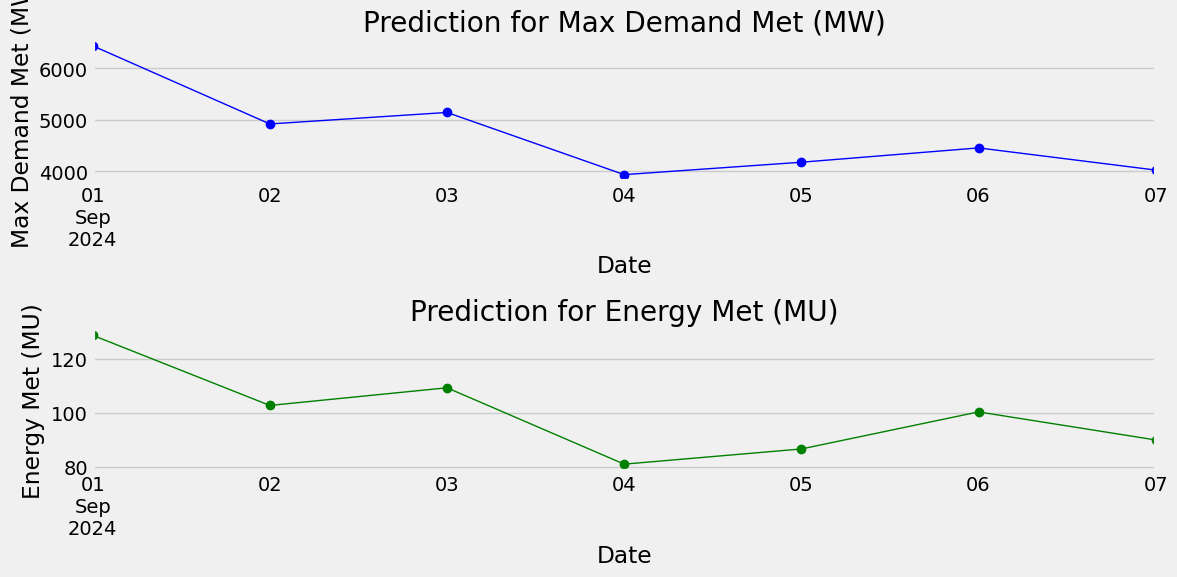

In [27]:
for target in TARGET:
    ff[f'prediction_{target}'] = models[target].predict(ff[FEATURES])

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
ff['prediction_Max Demand Met (MW)'].plot(color='blue', marker='o', linestyle='-', linewidth=1)
plt.title('Prediction for Max Demand Met (MW)')
plt.xlabel('Date')
plt.ylabel('Max Demand Met (MW)')
plt.grid(True)

plt.subplot(2, 1, 2)
ff['prediction_Energy Met (MU)'].plot(color='green', marker='o', linestyle='-', linewidth=1)
plt.title('Prediction for Energy Met (MU)')
plt.xlabel('Date')
plt.ylabel('Energy Met (MU)')
plt.grid(True)

plt.tight_layout()
plt.show()

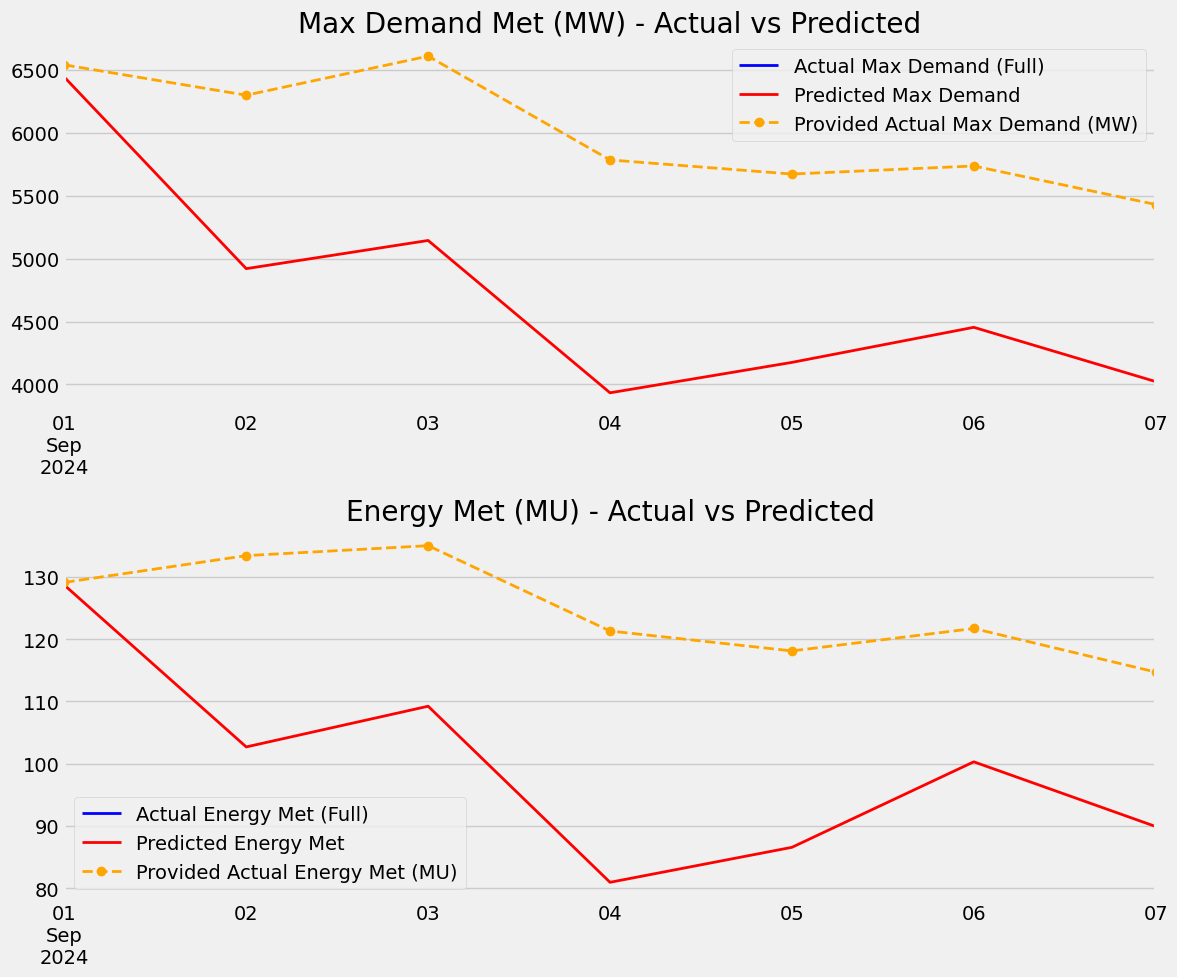

In [28]:
actual_max_demand_met = [6538, 6297, 6607, 5783, 5671, 5735, 5429]
actual_energy_met = [129.1, 133.4, 135, 121.3, 118.1, 121.7, 114.7]

daywise_dates = ff.index[:7]  

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
ff['Max Demand Met (MW)'].plot(label='Actual Max Demand (Full)', color='blue', lw=2)
ff['prediction_Max Demand Met (MW)'].plot(label='Predicted Max Demand', color='red', lw=2)

plt.plot(daywise_dates, actual_max_demand_met, 'o--', label='Provided Actual Max Demand (MW)', color='orange', lw=2)

plt.title('Max Demand Met (MW) - Actual vs Predicted')
plt.legend()

plt.subplot(2, 1, 2)
ff['Energy Met (MU)'].plot(label='Actual Energy Met (Full)', color='blue', lw=2)
ff['prediction_Energy Met (MU)'].plot(label='Predicted Energy Met', color='red', lw=2)

plt.plot(daywise_dates, actual_energy_met, 'o--', label='Provided Actual Energy Met (MU)', color='orange', lw=2)

plt.title('Energy Met (MU) - Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()


In [29]:
actual_max_demand_met = [6538, 6297, 6607, 5783, 5671, 5735, 5429]
actual_energy_met = [129.1, 133.4, 135, 121.3, 118.1, 121.7, 114.7]

ff['Actual_Max_Demand_Met (MW)'] = actual_max_demand_met
ff['Actual_Energy_Met (MU)'] = actual_energy_met

ff['Diff_Max_Demand_Met (MW)'] = ff['Actual_Max_Demand_Met (MW)'] - ff['prediction_Max Demand Met (MW)']
ff['Diff_Energy_Met (MU)'] = ff['Actual_Energy_Met (MU)'] - ff['prediction_Energy Met (MU)']

ff['Perc_Diff_Max_Demand_Met (MW)'] = (ff['Diff_Max_Demand_Met (MW)'] / ff['Actual_Max_Demand_Met (MW)']) * 100
ff['Perc_Diff_Energy_Met (MU)'] = (ff['Diff_Energy_Met (MU)'] / ff['Actual_Energy_Met (MU)']) * 100

comparison_df = pd.DataFrame({
    'Date': ff.index,  # Assuming ff has the Date index
    'Actual_Max_Demand_Met (MW)': ff['Actual_Max_Demand_Met (MW)'],
    'Predicted_Max_Demand_Met (MW)': ff['prediction_Max Demand Met (MW)'],
    'Diff_Max_Demand_Met (MW)': ff['Diff_Max_Demand_Met (MW)'],
    'Perc_Diff_Max_Demand_Met (MW)': ff['Perc_Diff_Max_Demand_Met (MW)'],
    'Actual_Energy_Met (MU)': ff['Actual_Energy_Met (MU)'],
    'Predicted_Energy_Met (MU)': ff['prediction_Energy Met (MU)'],
    'Diff_Energy_Met (MU)': ff['Diff_Energy_Met (MU)'],
    'Perc_Diff_Energy_Met (MU)': ff['Perc_Diff_Energy_Met (MU)']
})

comparison_df_rounded = comparison_df.round(2)

print(comparison_df_rounded)

                 Date  Actual_Max_Demand_Met (MW)  \
2024-09-01 2024-09-01                        6538   
2024-09-02 2024-09-02                        6297   
2024-09-03 2024-09-03                        6607   
2024-09-04 2024-09-04                        5783   
2024-09-05 2024-09-05                        5671   
2024-09-06 2024-09-06                        5735   
2024-09-07 2024-09-07                        5429   

            Predicted_Max_Demand_Met (MW)  Diff_Max_Demand_Met (MW)  \
2024-09-01                    6440.379883                     97.62   
2024-09-02                    4919.660156                   1377.34   
2024-09-03                    5143.470215                   1463.53   
2024-09-04                    3933.820068                   1849.18   
2024-09-05                    4175.319824                   1495.68   
2024-09-06                    4453.870117                   1281.13   
2024-09-07                    4022.919922                   1406.08   

      